## Project 'Die Zeit' churn prediction
by Sebastian Fuhrer fuhrer_sebastian@web.de

## Objective 

Aufgabe: 

Churn Prediction (Wer kündigt sein Abonnement innerhalb des nächsten Jahres?)
Anhand der vergangenen Kündigungen wird ein Modell trainiert, welches die Affinität zur Kündigung pro Auftrag vorhersagt.

Churn Prevention-Mailing:

Wir sehen die Ansprache über den Kanal EMail kann bei der richtigen Kommunikation unsere Abonnenten vom Kündigen abhalten. Da wir aber unsere Kunden nicht übermäßig mit Emails ‘erfreuen’ möchten, erhaltenen nur die kündigungsaffinisten Dezile diese Maßnahme per Email.


## Set up

In [1]:
%reset -fs

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

%matplotlib inline
plt.style.use("ggplot")

# Set random seed 
RSEED = 42

In [3]:
df = pd.read_csv('f_chtr_churn_traintable_nf.csv')

## EDA

### Feature description of the important features

* **auftrag_new_id** - Identifier
* **liefer_beginn_evt** - Order intake
* **kanal** - Acquisition channel
* **objekt_name** - Die Zeit / Zeit Digital / Die Zeit - Christ & Welt
* **aboform_name** - Type of subscription
* **zahlung_rhythmus_name** - Period of payment for the subscription
* **lesedauer** - Order received until end of order in months
* **rechnungsmonat** - Is it a billing month
* **zahlung_weg_name** - How is paid
* **studentenabo** - Special form of subscription for students
* **ort** - In which place the person lives
* **metropole** - Does the person live in the city or in the country
* **land_iso_code** - Country code Germany Austria Switzerland and others
* **shop_kauf** - How often did the person shop in Die Zeit's shop
* **unterbrechung** - Has the person interrupted their subscription?
* **anrede** - Salutation
* **titel** - academic title, no title and others
* **nl_aktivitaet** - Number on how many Newsletter in the house
* **received_anzahl** Email transaction data / how many received in one week/ one month/ three month/ six month
* **opened_anzahl** - Email transaction data / E-Mail how often opened 
* **clicked_anzahl** - Email transaction data / clicked on E-Mail 
* **unsubscribed_anzahl** - Email transaction data
* **kuendigungs_eingangs_datum** - if cancellation has been received on that day
* **churn** - Target variable - 
* **date_x** - Cancellation or random date 

We only consider households with a maximum of 4 subscriptions

In [4]:
df1 = df.copy()

In [5]:
df1 = df1.query('cnt_abo <= 3')

In [6]:
df1 = df1.reset_index(drop=True)

In [7]:
df1.head(2)

,Unnamed: 0,auftrag_new_id,liefer_beginn_evt,kanal,objekt_name,aboform_name,zahlung_rhythmus_name,lesedauer,rechnungsmonat,zahlung_weg_name,...,openrate_zeitbrief_1w,clickrate_zeitbrief_1w,openrate_zeitbrief_1m,clickrate_zeitbrief_1m,openrate_zeitbrief_3m,clickrate_zeitbrief_3m,training_set,kuendigungs_eingangs_datum,churn,date_x
0,3,25B535B7-D3F9-4804-9FFE-A8C813C8A593,2013-10-17,andere,ZEIT Digital,Festabo,jährlich,72,0,Bankeinzug,...,1.0,0.0,0.67,0.0,0.36,0.0,1,NaN,0,2019-10-02 00:00:00
1,4,C348C873-8229-4F4F-8B50-5B4C06B2E872,2013-09-12,andere,ZEIT Digital,Festabo,vierteljährlich,70,0,Bankeinzug,...,0.0,0.0,0.00,0.0,0.00,0.0,1,NaN,0,2019-07-30 00:00:00


### Analyzing the data  

In [8]:
df1.shape

(175130, 171)

The data set contains 175130 customers and 171 data points on each customer.

In [9]:
#Show all of the column names
df1.columns.values

array(['Unnamed: 0', 'auftrag_new_id', 'liefer_beginn_evt', 'kanal',
       'objekt_name', 'aboform_name', 'zahlung_rhythmus_name',
       'lesedauer', 'rechnungsmonat', 'zahlung_weg_name', 'studentenabo',
       'plz_1', 'plz_2', 'plz_3', 'ort', 'metropole', 'land_iso_code',
       'shop_kauf', 'unterbrechung', 'anrede', 'titel', 'avg_churn',
       'email_am_kunden', 'zon_che_opt_in', 'zon_sit_opt_in',
       'zon_zp_grey', 'zon_premium', 'zon_boa', 'zon_kommentar',
       'zon_sonstige', 'zon_zp_red', 'zon_rawr', 'zon_community',
       'zon_app_sonstige', 'zon_schach', 'zon_blog_kommentare',
       'zon_quiz', 'cnt_abo', 'cnt_abo_diezeit',
       'cnt_abo_diezeit_digital', 'cnt_abo_magazin',
       'cnt_umwandlungsstatus2_dkey', 'abo_registrierung_min',
       'nl_zeitbrief', 'nl_zeitshop', 'nl_zeitverlag_hamburg',
       'nl_fdz_organisch', 'nl_blacklist_sum', 'nl_bounced_sum',
       'nl_aktivitaet', 'nl_registrierung_min', 'nl_sperrliste_sum',
       'nl_opt_in_sum', 'boa_reg', 

In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175130 entries, 0 to 175129
Columns: 171 entries, Unnamed: 0 to date_x
dtypes: float64(32), int64(121), object(18)
memory usage: 228.5+ MB


In [11]:
#Check for na or missing data 
df1.isna().sum()

Unnamed: 0                               0
auftrag_new_id                           0
liefer_beginn_evt                        0
kanal                                    0
objekt_name                              0
aboform_name                             0
zahlung_rhythmus_name                    0
lesedauer                                0
rechnungsmonat                           0
zahlung_weg_name                         0
studentenabo                             0
plz_1                                    0
plz_2                                    0
plz_3                                    0
ort                                     85
metropole                                0
land_iso_code                            0
shop_kauf                                0
unterbrechung                            0
anrede                                   0
titel                                    0
avg_churn                                0
email_am_kunden                         12
zon_che_opt

The features 'ort', 'email_am_kunden' and 'kuendigungs_eingangs_datum' have missing data points, which we will deal with later.

In [12]:
#Show statistics on the current data
df1.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,175130.0,101203.24,60491.12,3.0,48473.25,99218.50,153111.75,209040.00
lesedauer,175130.0,33.32,21.85,0.0,14.00,29.00,48.00,88.00
rechnungsmonat,175130.0,0.10,0.30,0.0,0.00,0.00,0.00,1.00
studentenabo,175130.0,0.11,0.32,0.0,0.00,0.00,0.00,1.00
metropole,175130.0,0.29,0.46,0.0,0.00,0.00,1.00,1.00
shop_kauf,175130.0,0.44,1.99,0.0,0.00,0.00,0.00,77.00
unterbrechung,175130.0,0.09,0.29,0.0,0.00,0.00,0.00,1.00
avg_churn,175130.0,0.31,0.15,0.1,0.18,0.28,0.39,0.70
email_am_kunden,175118.0,0.93,0.25,0.0,1.00,1.00,1.00,1.00
zon_che_opt_in,175130.0,0.00,0.06,0.0,0.00,0.00,0.00,2.00


From the statistics above, we can see that the amount of variation in some features is very little. If a feature is mostly all the same value then will the model not learn anything about it.

So we will drop all features which have a standard deviation < 0.1 later on.

### Missing Data

In [13]:
missing = pd.DataFrame(df1.isnull().sum(), columns=['Number'])
missing['Percentage'] = round(missing.Number / df1.shape[0] * 100, 1)
missing[missing.Number != 0]

,Number,Percentage
ort,85,0.0
email_am_kunden,12,0.0
kuendigungs_eingangs_datum,122166,69.8


Since 'kuendigungs_eingangs_datum' would cause data leakage, we can remove the feature from our data. 
The features 'ort' and 'email_am_kunden' has only 0.0 percent off missing data, so we will remove the 85 plus the 12 rows.

In [14]:
df1.drop(['kuendigungs_eingangs_datum'],axis=1,inplace=True)

In [15]:
df1.dropna(inplace=True)

In [16]:
df1 = df1.reset_index(drop=True)

In [17]:
df1.shape

(175045, 170)

### Get the number of customers that churned

Next, we have a look at the number of customers that churned and of the customers that still have asubscription. 

In [18]:
df1['churn'].value_counts()

0    122140
1     52905
Name: churn, dtype: int64

About 52.964 customers churned and 122.166 still have a subscription from 'Die Zeit'.

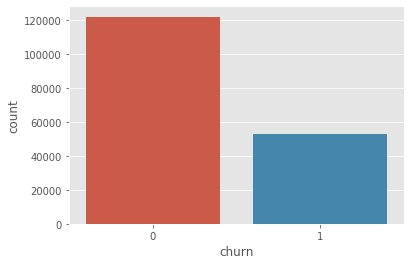

In [19]:
#Visualize the count of customer churn
sns.countplot(df1['churn'])

Target variable distribution is not balanced as there are more non-churned than churned users.

We want to know what percentage of customers are leaving.

In [20]:
#What percentage of customers are leaving ?
retained = df1[df1.churn == 0]
churned = df1[df1.churn == 1]
num_retained = retained.shape[0]
num_churned = churned.shape[0]

#Print the percentage of customers that stayed and left
print( num_retained / (num_retained + num_churned) * 100 , "% of customers still haven an subscription.")

print( num_churned / (num_retained + num_churned) * 100 , "% of customers canceled subscription.")

69.77634322602759 % of customers still haven an subscription.
30.223656773972408 % of customers canceled subscription.


So, about 69.76% of the customers still have an subscription and about 30.24% of the costumers canceled their subscription. This is an important information, because it means that just by always guessing a random customer to still have an subscription from the data set, we have a 69.76% chance of guessing correctly. So, we want the model´s accuracy to classify/predict if a customer will churn to be higher than that percentage.

### Akquisekanal

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

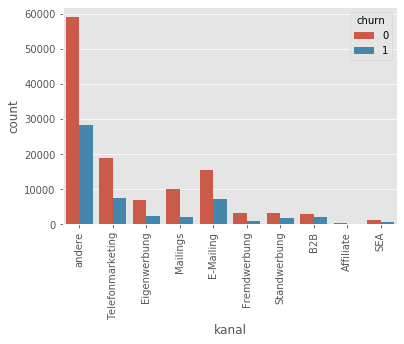

In [21]:
#Visualize the churn count for 'kanal'
sns.countplot(x='kanal', hue='churn', data = df1)
plt.xticks(rotation=90)

We can see from the bar chart that the churn rate is highest for 'Telefonmarketing', 'E-Mailing' and 'andere'.

### Objekt

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

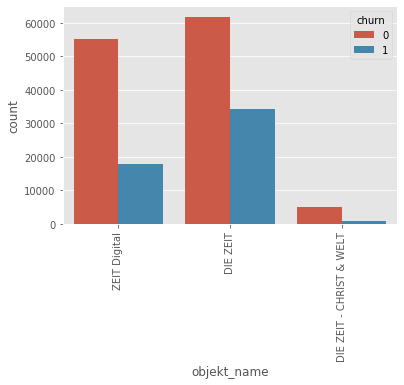

In [22]:
#Visualize the churn count for 'objekt_name'
sns.countplot(x='objekt_name', hue='churn', data = df1)
plt.xticks(rotation=90)

Customers with the 'Die Zeit' subscription have by far the highest churn rate.

### Art des Abos

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

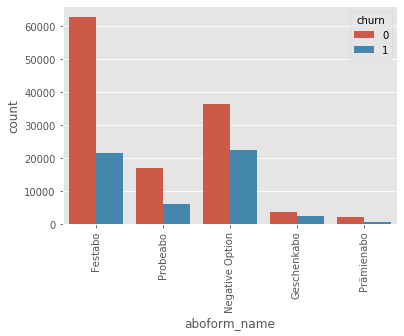

In [23]:
#Visualize the churn count for 'aboform_name'
sns.countplot(x='aboform_name', hue='churn', data = df1)
plt.xticks(rotation=90)

The highest churn rate has the 'Negative Option'. This opens up when you know that these are free subscriptions that have been converted into paid subscriptions.

### Zahlungs Rhythmus Name

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

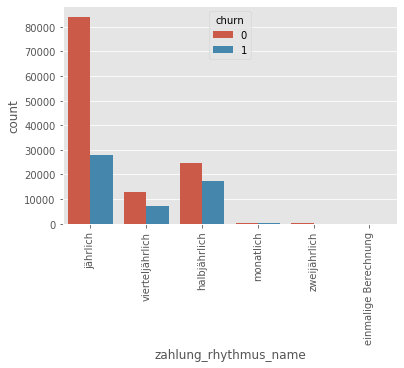

In [24]:
#Visualize the churn count for 'zahlung_rhythmus_name'
sns.countplot(x='zahlung_rhythmus_name', hue='churn', data = df1)
plt.xticks(rotation=90)

### Auftragseingang bis Ende Auftrag

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88]),
 <a list of 89 Text xticklabel objects>)

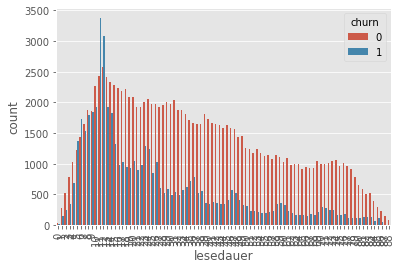

In [25]:
#Visualize the churn count for 'lesedauer'
sns.countplot(x='lesedauer', hue='churn', data = df1)
plt.xticks(rotation=90)

Here we can guess that the churn rate decreases with the 'lesedauer'.

### Date_x und Lieferbeginn

In [26]:
df1['date_x_month'] = df1['date_x'].str[5:7].astype(int)

In [27]:
df1['liefer_beginn_num'] = df1['liefer_beginn_evt'].str[:4].astype('int') + df1['liefer_beginn_evt'].str[5:7].astype('float')/12 + df1['liefer_beginn_evt'].str[8:10].astype('float')/365

In [28]:
df1.head(1)

,Unnamed: 0,auftrag_new_id,liefer_beginn_evt,kanal,objekt_name,aboform_name,zahlung_rhythmus_name,lesedauer,rechnungsmonat,zahlung_weg_name,...,clickrate_zeitbrief_1w,openrate_zeitbrief_1m,clickrate_zeitbrief_1m,openrate_zeitbrief_3m,clickrate_zeitbrief_3m,training_set,churn,date_x,date_x_month,liefer_beginn_num
0,3,25B535B7-D3F9-4804-9FFE-A8C813C8A593,2013-10-17,andere,ZEIT Digital,Festabo,jährlich,72,0,Bankeinzug,...,0.0,0.67,0.0,0.36,0.0,1,0,2019-10-02 00:00:00,10,2013.879909


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbf0b353278>,
      dtype=object)

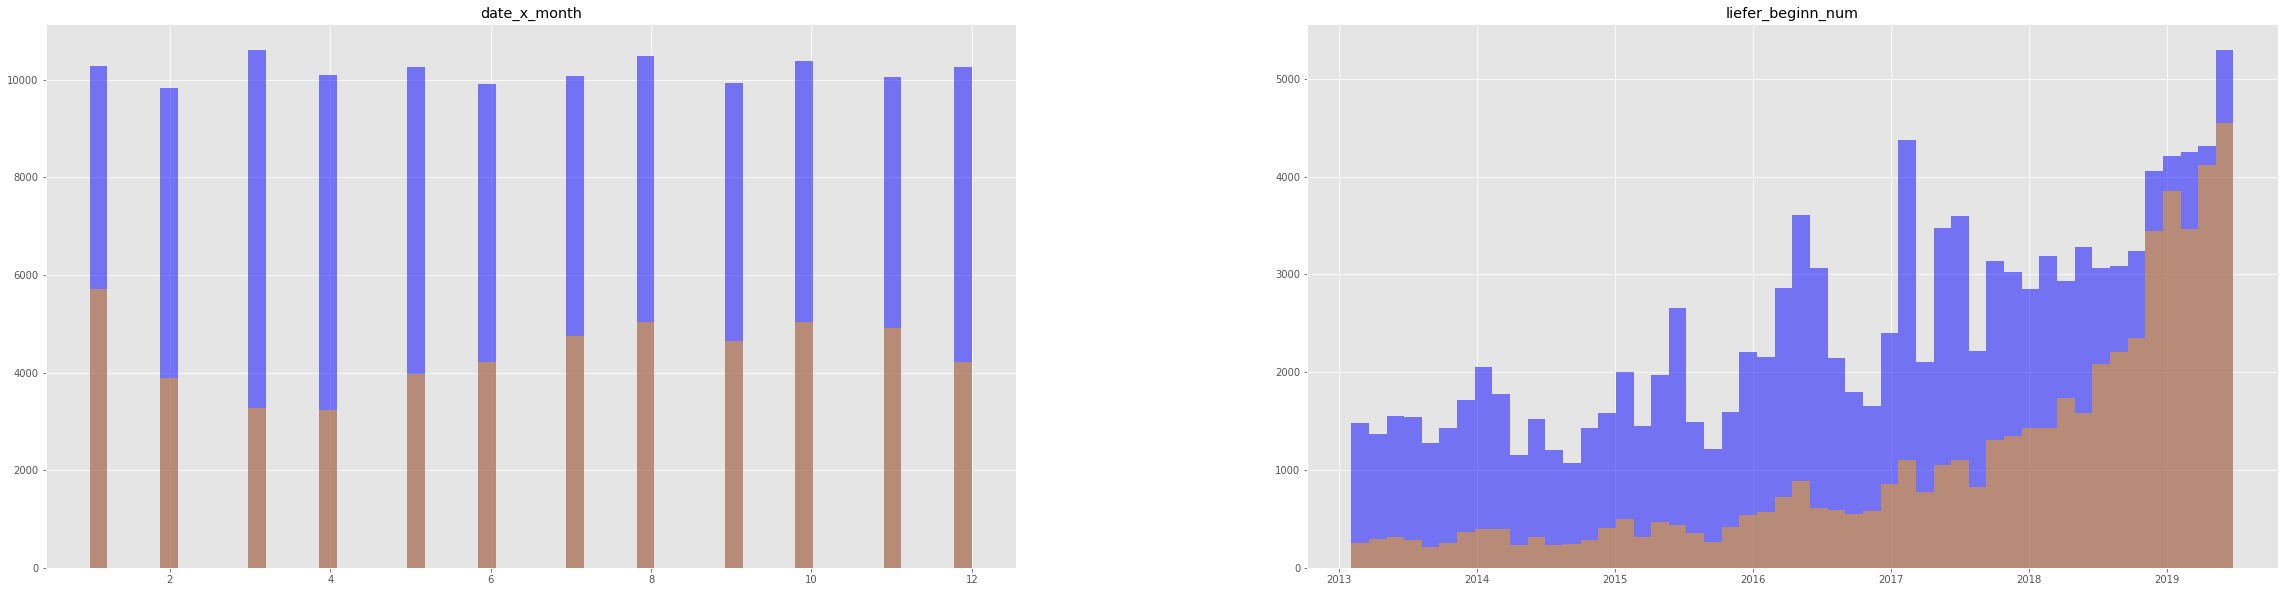

In [29]:
numerical_features = ['date_x_month', 'liefer_beginn_num']
fig, ax = plt.subplots(1, 2, figsize=(40, 10))
df1[df1.churn == 0][numerical_features].hist(bins=50, color="blue",
alpha=0.5, ax=ax)
df1[df1.churn == 1][numerical_features].hist(bins=50, color="orange",
alpha=0.5, ax=ax)



### Handelt es sich um einen Rechnungsmonat

(array([0, 1]), <a list of 2 Text xticklabel objects>)

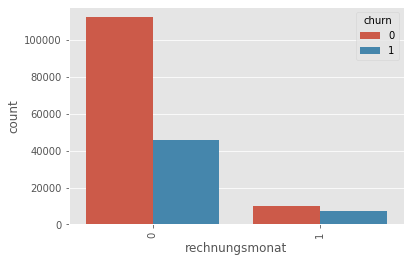

In [30]:
#Visualize the churn count for 'zahlung_rhythmus_name'
sns.countplot(x='rechnungsmonat', hue='churn', data = df1)
plt.xticks(rotation=90)

### Name des Zahlungsweg

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

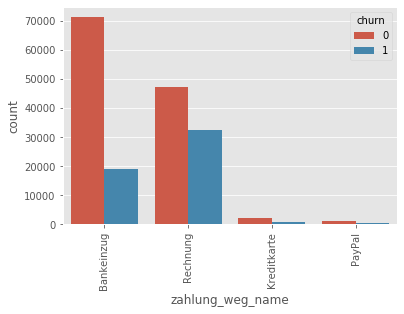

In [31]:
#Visualize the churn count for 'zahlung_rhythmus_name'
sns.countplot(x='zahlung_weg_name', hue='churn', data = df1)
plt.xticks(rotation=90)

### Studentenabo

(array([0, 1]), <a list of 2 Text xticklabel objects>)

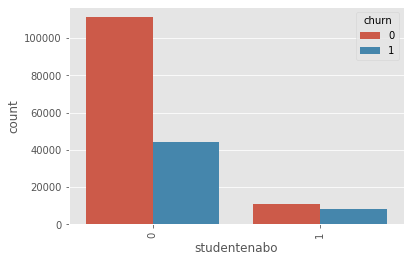

In [32]:
#Visualize the churn count for 'zahlung_rhythmus_name'
sns.countplot(x='studentenabo', hue='churn', data = df1)
plt.xticks(rotation=90)

### Postleitzahl

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

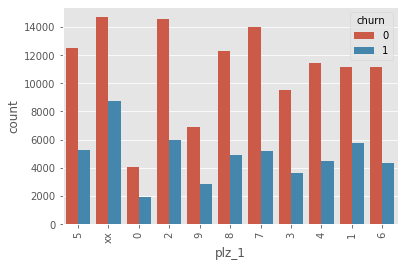

In [33]:
#Visualize the churn count for 'zahlung_rhythmus_name'
sns.countplot(x='plz_1', hue='churn', data = df1)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96]),
 <a list of 97 Text xticklabel objects>)

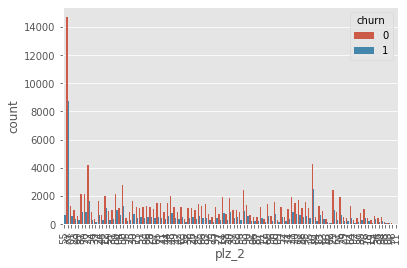

In [34]:
#Visualize the churn count for 'zahlung_rhythmus_name'
sns.countplot(x='plz_2', hue='churn', data = df1)
plt.xticks(rotation=90)

### Metropole/Land ISO Code

(array([0, 1]), <a list of 2 Text xticklabel objects>)

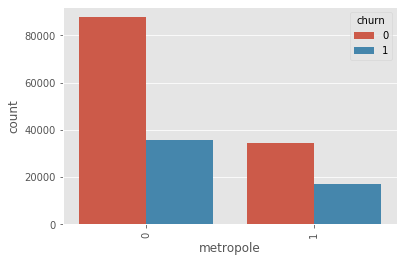

In [35]:
#Visualize the churn count for 'zahlung_rhythmus_name'
sns.countplot(x='metropole', hue='churn', data = df1)
plt.xticks(rotation=90)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

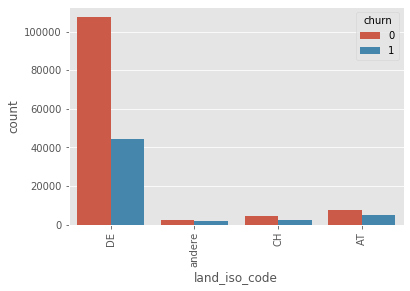

In [36]:
#Visualize the churn count for 'zahlung_rhythmus_name'
sns.countplot(x='land_iso_code', hue='churn', data = df1)
plt.xticks(rotation=90)

### Zeit Shop 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54]),
 <a list of 55 Text xticklabel objects>)

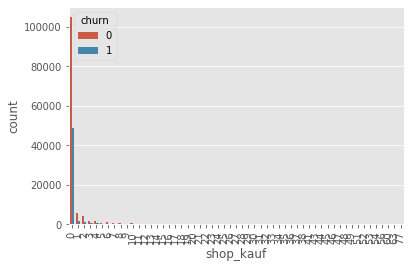

In [37]:
#Visualize the churn count for 'zahlung_rhythmus_name'
sns.countplot(x='shop_kauf', hue='churn', data = df1)
plt.xticks(rotation=90)

### Unterbrechung des Abonnements

(array([0, 1]), <a list of 2 Text xticklabel objects>)

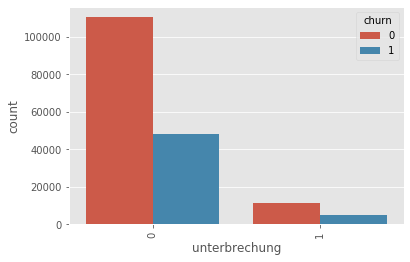

In [38]:
#Visualize the churn count for 'zahlung_rhythmus_name'
sns.countplot(x='unterbrechung', hue='churn', data = df1)
plt.xticks(rotation=90)

### Anrede/Titel

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

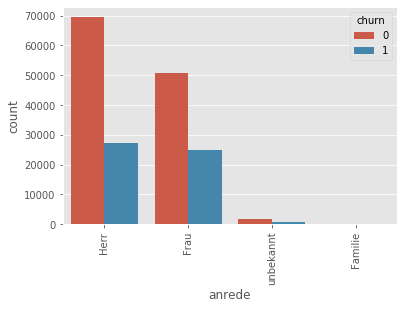

In [39]:
#Visualize the churn count for 'zahlung_rhythmus_name'
sns.countplot(x='anrede', hue='churn', data = df1)
plt.xticks(rotation=90)

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

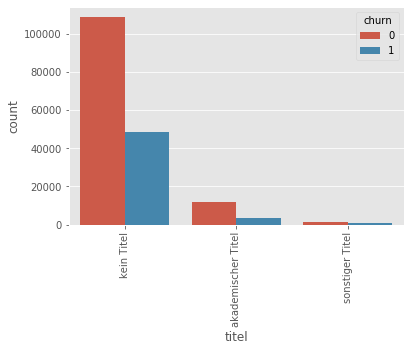

In [40]:
#Visualize the churn count for 'zahlung_rhythmus_name'
sns.countplot(x='titel', hue='churn', data = df1)
plt.xticks(rotation=90)

### Some important features

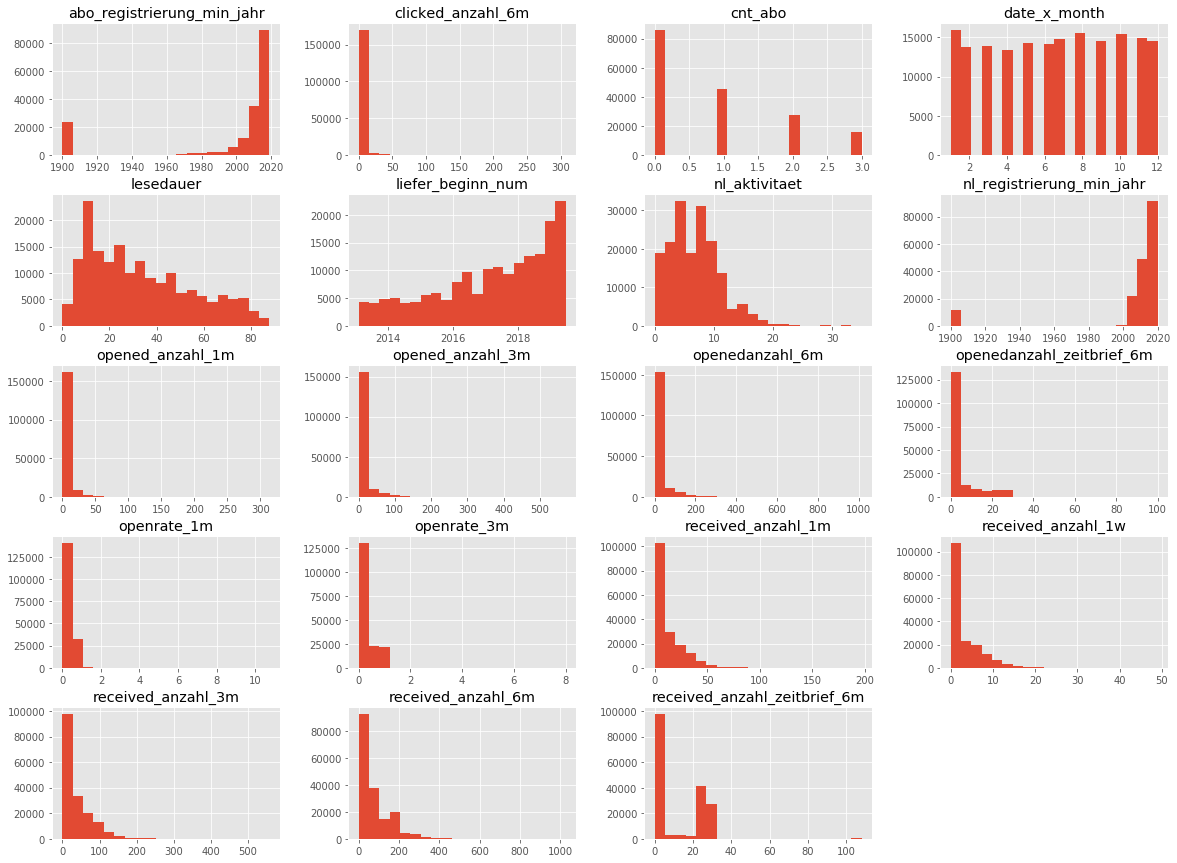

In [79]:
im_F = df1[['liefer_beginn_num', 'lesedauer', 'nl_aktivitaet', 'abo_registrierung_min_jahr',
                   'nl_registrierung_min_jahr', 'received_anzahl_6m', 'date_x_month', 'received_anzahl_3m',
                   'received_anzahl_1m', 'openedanzahl_6m', 'openrate_3m', 'opened_anzahl_3m', 'received_anzahl_1w',
                   'openrate_1m', 'opened_anzahl_1m', 'received_anzahl_zeitbrief_6m', 'openedanzahl_zeitbrief_6m',
                   'clicked_anzahl_6m', 'cnt_abo']].hist(bins=20, figsize=(20, 15), layout=(5, 4))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbef5eb5da0>,
      dtype=object)

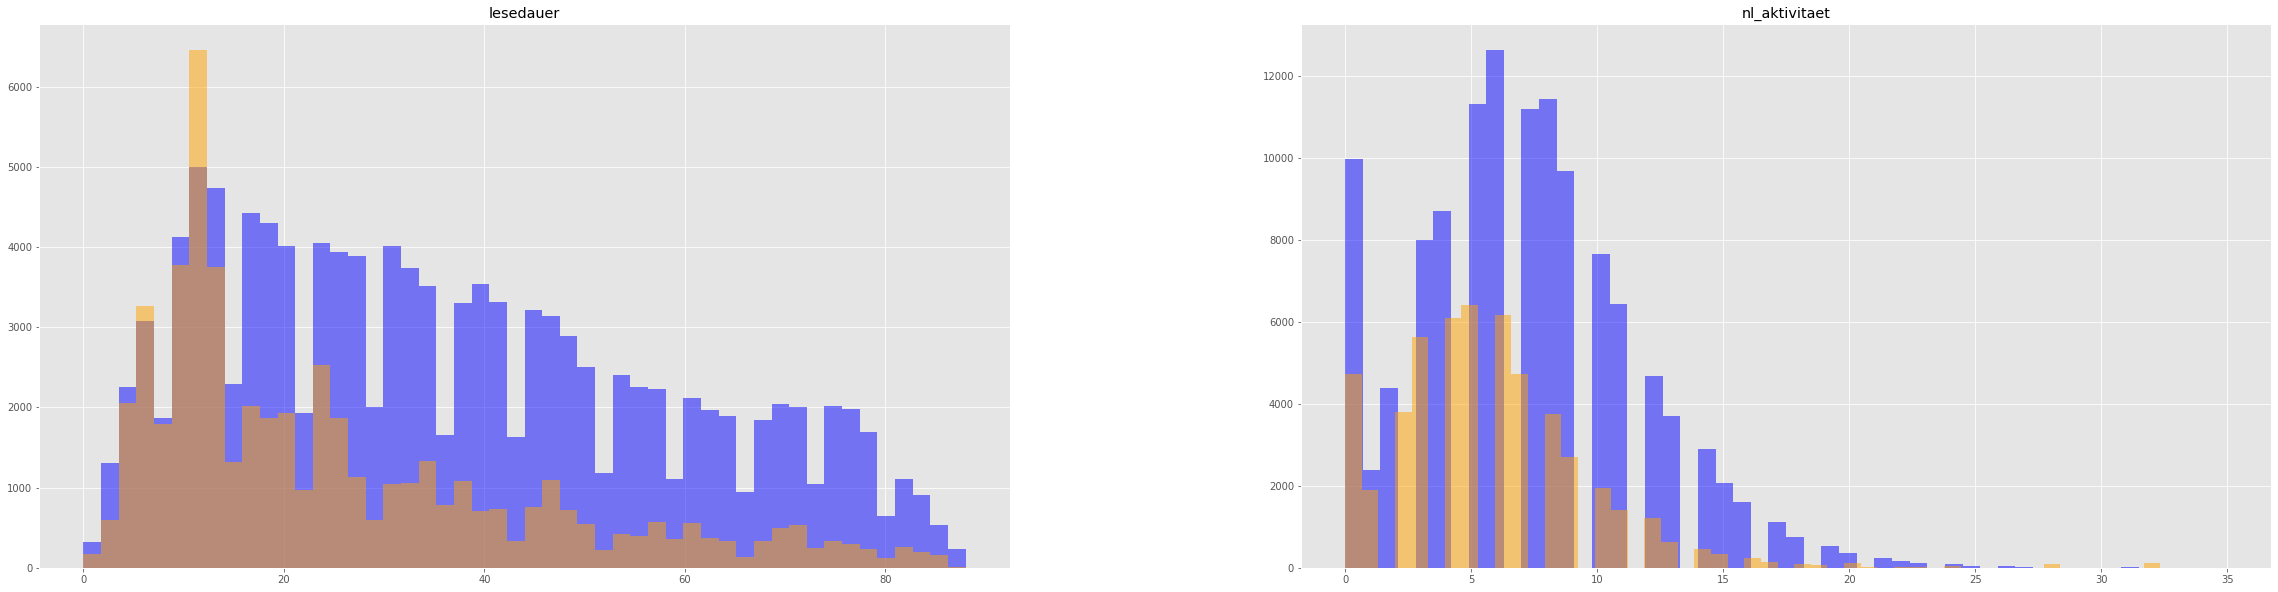

In [42]:
numerical_features = ['lesedauer', 'nl_aktivitaet']
fig, ax = plt.subplots(1, 2, figsize=(40, 10))
df1[df1.churn == 0][numerical_features].hist(bins=50, color="blue",
alpha=0.5, ax=ax)
df1[df1.churn == 1][numerical_features].hist(bins=50, color="orange",
alpha=0.5, ax=ax)

'lesedauer and 'nl_aktivitaet' are very important features to predict the potential churn customers. We can clearly see from the graphs that the churn rate shrinks with increasing 'lesedauer' and higher activity in the newsletter 'nl_aktivitaet'.

## Correlation Matrix

### Filter Method

The filtering here is done using correlation matrix and it is most commonly done using Pearson correlation.

In [43]:
#First we create a new DataFrame with only numerical features
numerics = ['int64', 'float64']

num_df = df1.select_dtypes(include=numerics)

In [44]:
num_df.shape

(175045, 155)

In [45]:
num_df.head(1)

,Unnamed: 0,lesedauer,rechnungsmonat,studentenabo,metropole,shop_kauf,unterbrechung,avg_churn,email_am_kunden,zon_che_opt_in,...,openrate_zeitbrief_1w,clickrate_zeitbrief_1w,openrate_zeitbrief_1m,clickrate_zeitbrief_1m,openrate_zeitbrief_3m,clickrate_zeitbrief_3m,training_set,churn,date_x_month,liefer_beginn_num
0,3,72,0,0,0,0,0,0.172959,1.0,0,...,1.0,0.0,0.67,0.0,0.36,0.0,1,0,10,2013.879909


#### First ten features 0-9

We look always at ten features plus the label 'churn' at the same time.

In [46]:
num_df1 = num_df.iloc[: ,[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 152]].copy()

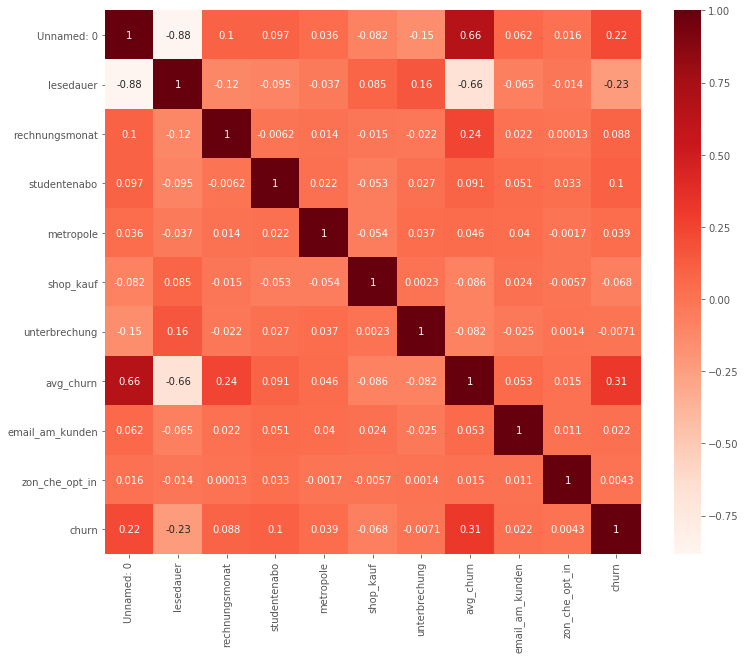

In [47]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = num_df1.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### 10-19 

In [48]:
num_df2 = num_df.iloc[: ,[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 152]].copy()

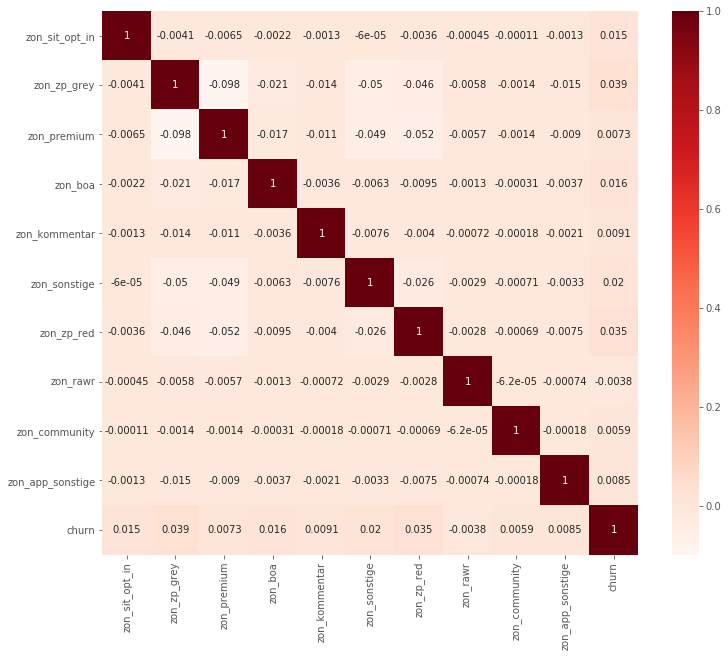

In [49]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = num_df2.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### 20-29

In [50]:
num_df3 = num_df.iloc[: ,[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 152]].copy()

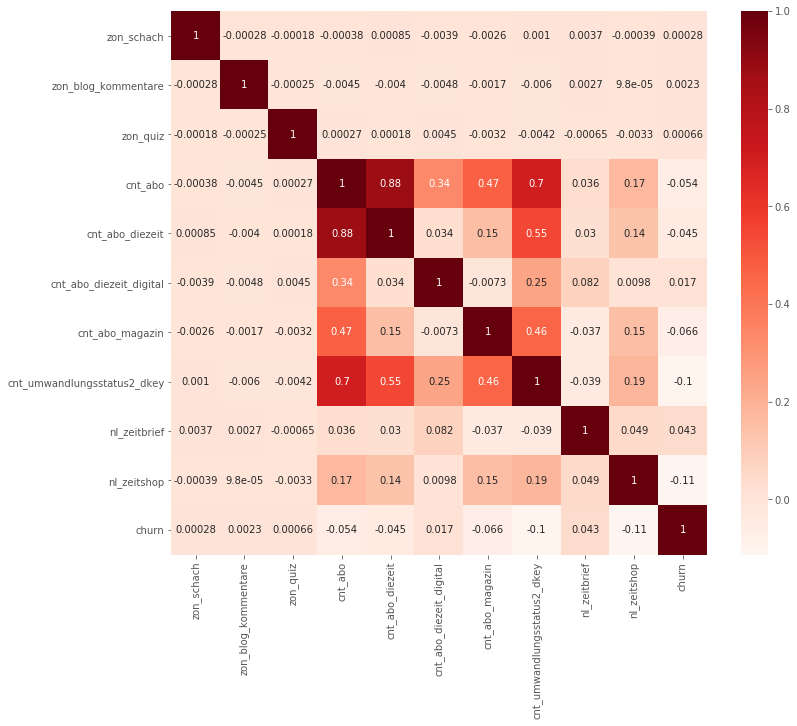

In [51]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = num_df3.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### 30-39

In [52]:
num_df4 = num_df.iloc[: ,[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 152]].copy()

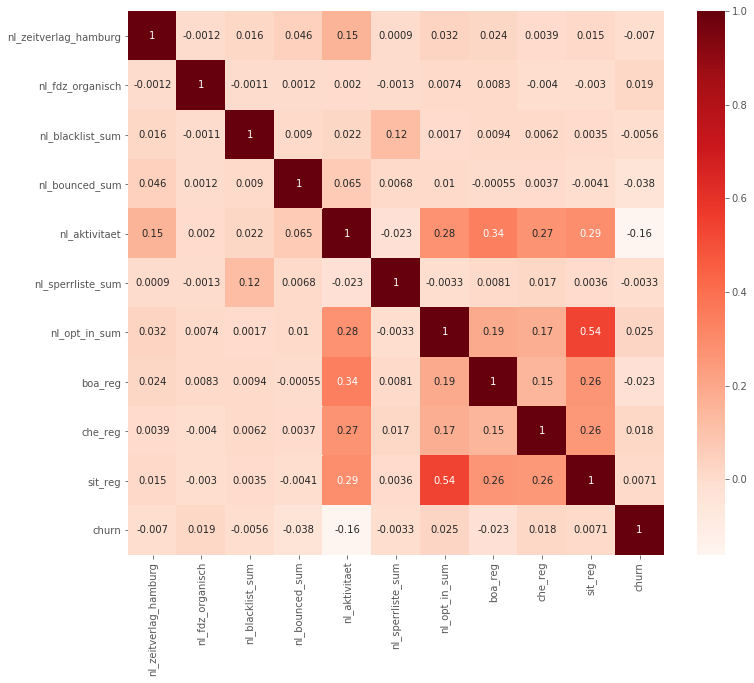

In [53]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = num_df4.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### 40-49

In [54]:
num_df5 = num_df.iloc[: ,[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 152]].copy()

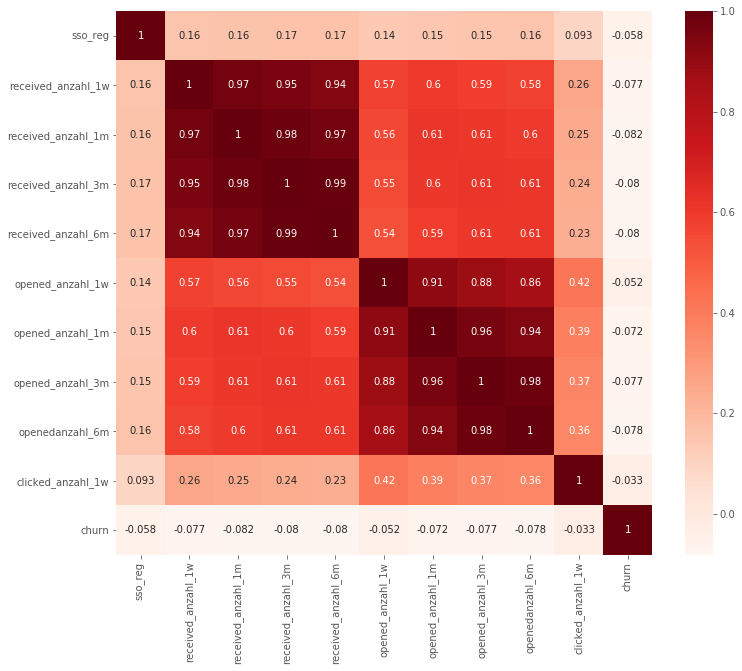

In [55]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = num_df5.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### 50-59

In [56]:
num_df6 = num_df.iloc[: ,[50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 152]].copy()

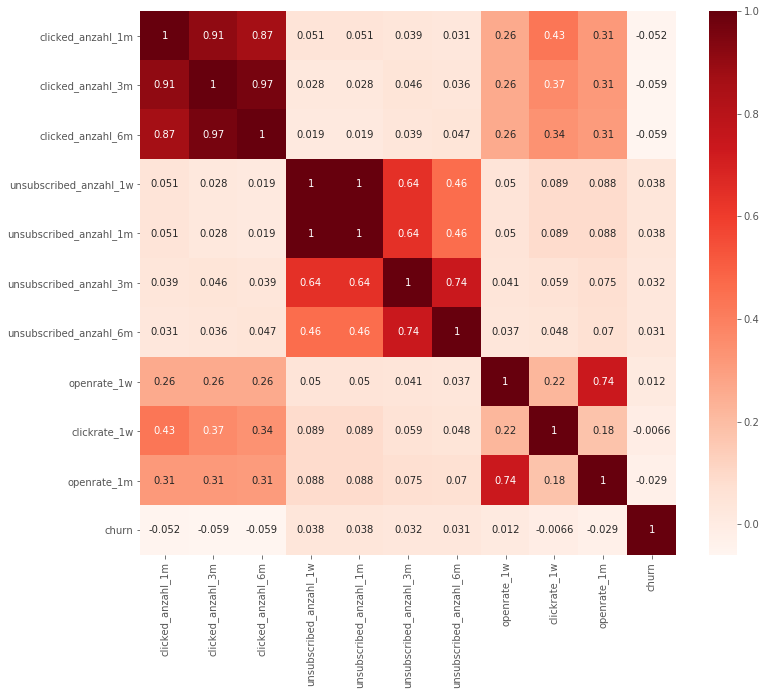

In [57]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = num_df6.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### 60-69

In [58]:
num_df7 = num_df.iloc[: ,[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 152]].copy()

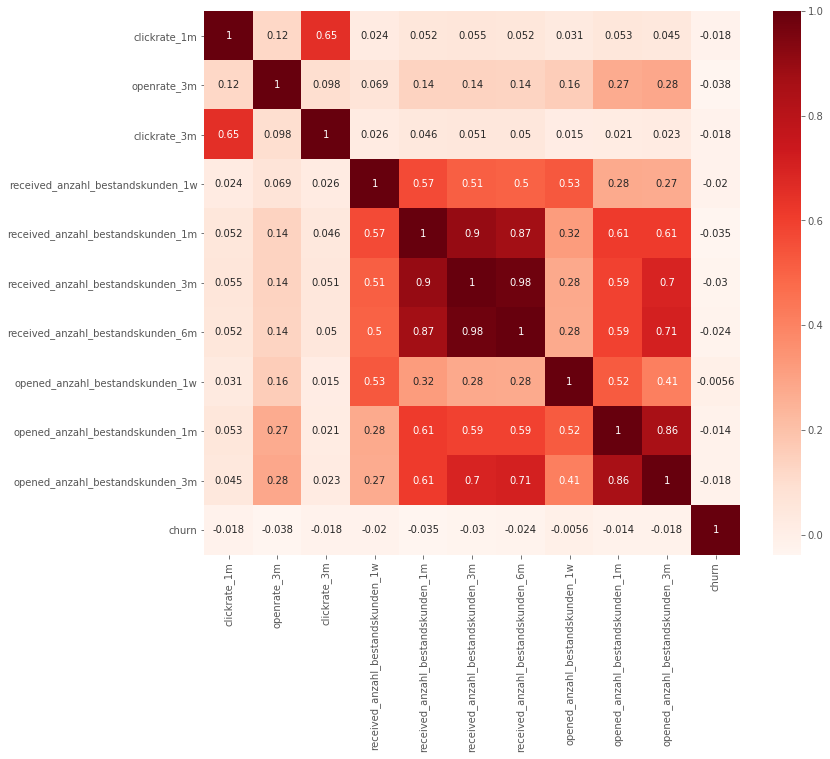

In [59]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = num_df7.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### 70-79

In [60]:
num_df8 = num_df.iloc[: ,[70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 152]].copy()

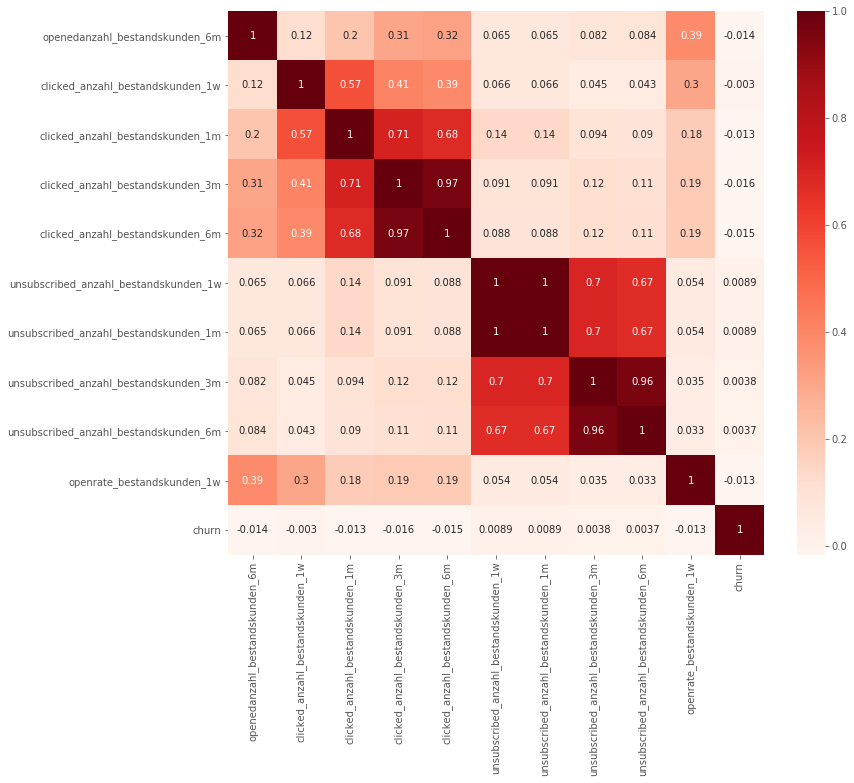

In [61]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = num_df8.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### 80-89

In [62]:
num_df9 = num_df.iloc[: ,[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 152]].copy()

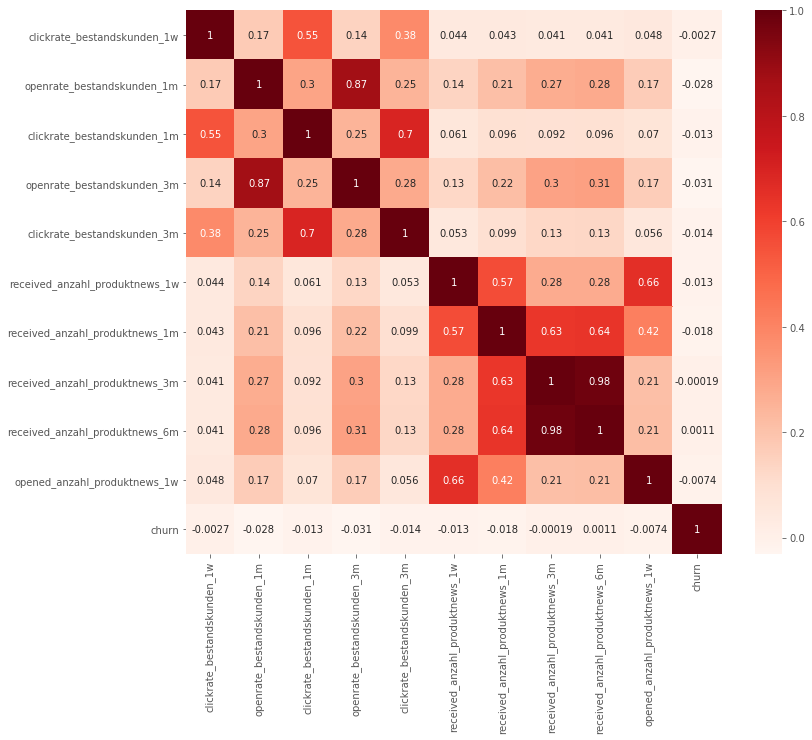

In [63]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = num_df9.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### 90-99

In [64]:
num_df10 = num_df.iloc[: ,[90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 152]].copy()

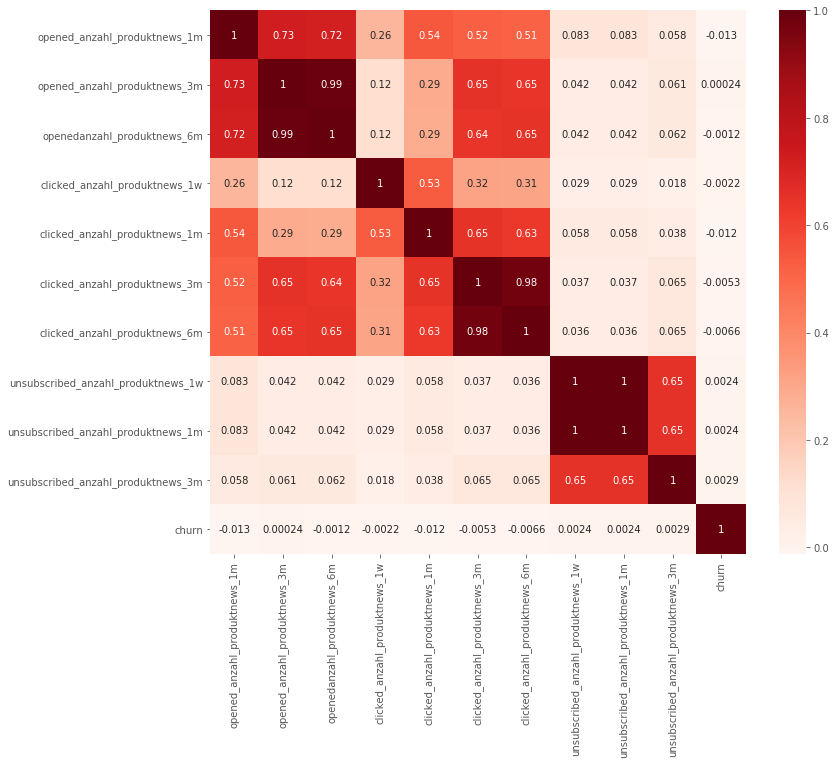

In [65]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = num_df10.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### 100-109

In [66]:
num_df11 = num_df.iloc[: ,[100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 152]].copy()

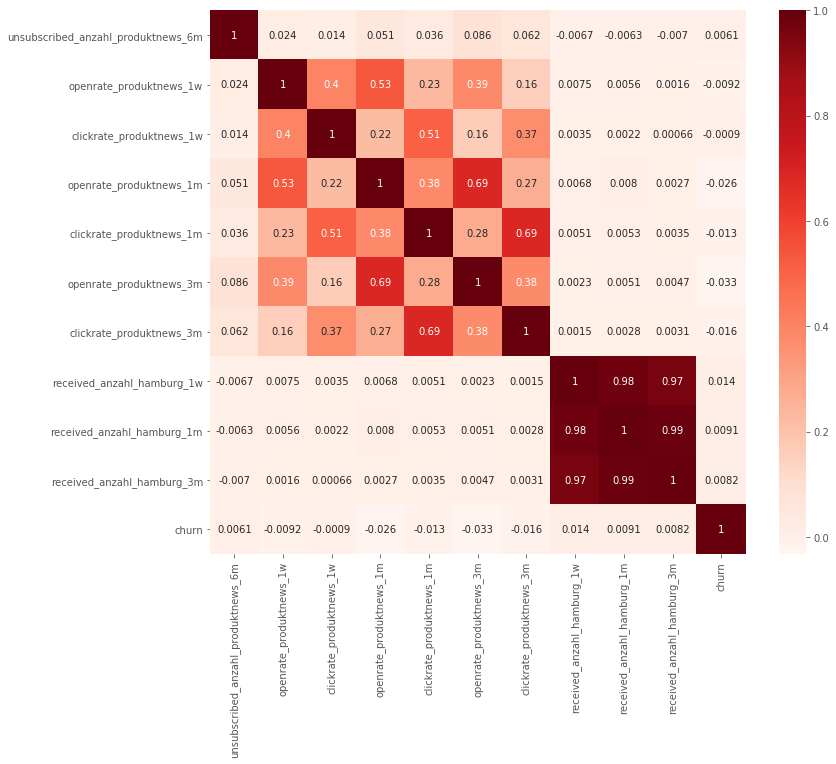

In [67]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = num_df11.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### 110-119

In [68]:
num_df12 = num_df.iloc[: ,[110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 152]].copy()

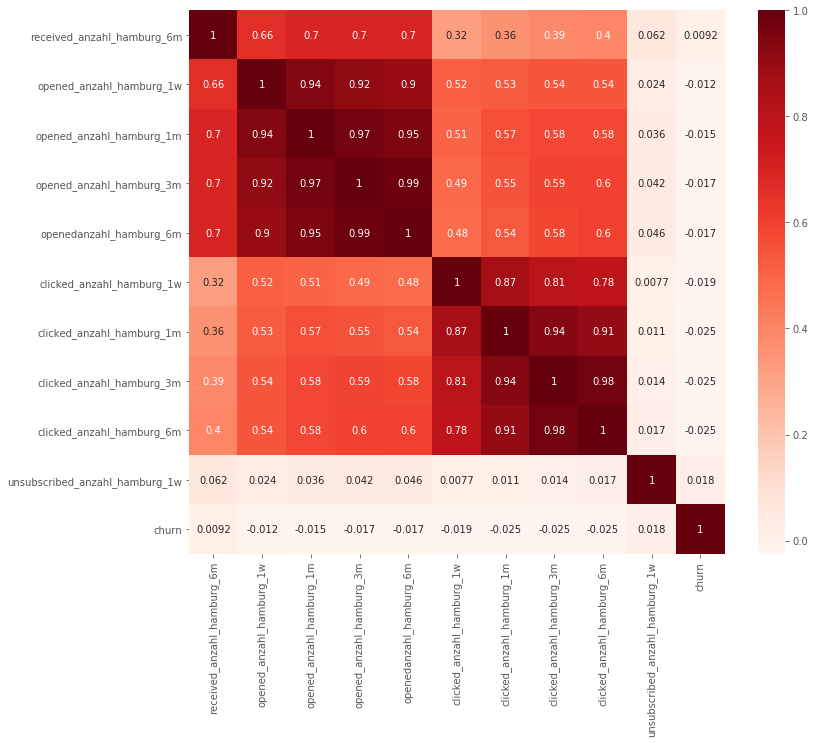

In [69]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = num_df12.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### 120-129

In [70]:
num_df13 = num_df.iloc[: ,[120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 152]].copy()

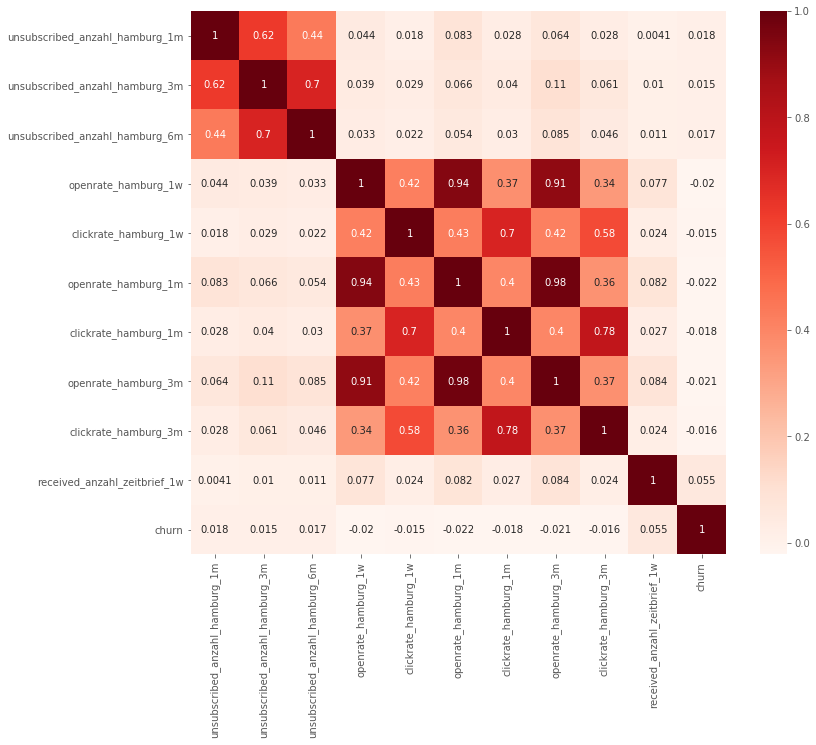

In [71]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = num_df13.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### 130-139

In [72]:
num_df14 = num_df.iloc[: ,[130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 152]].copy()

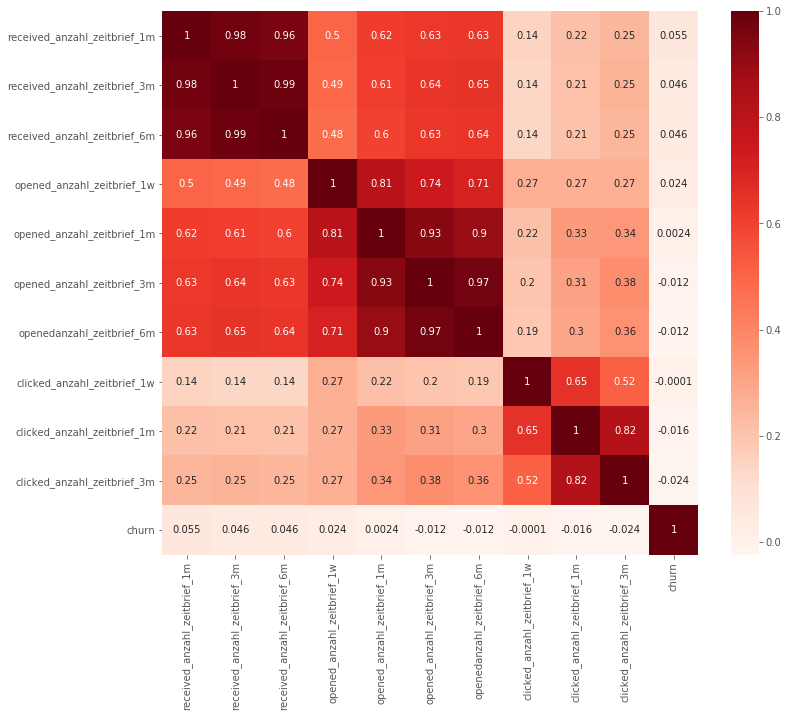

In [73]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = num_df14.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### 140-154

In [74]:
num_df15 = num_df.iloc[: ,[140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 152, 153, 154]].copy()

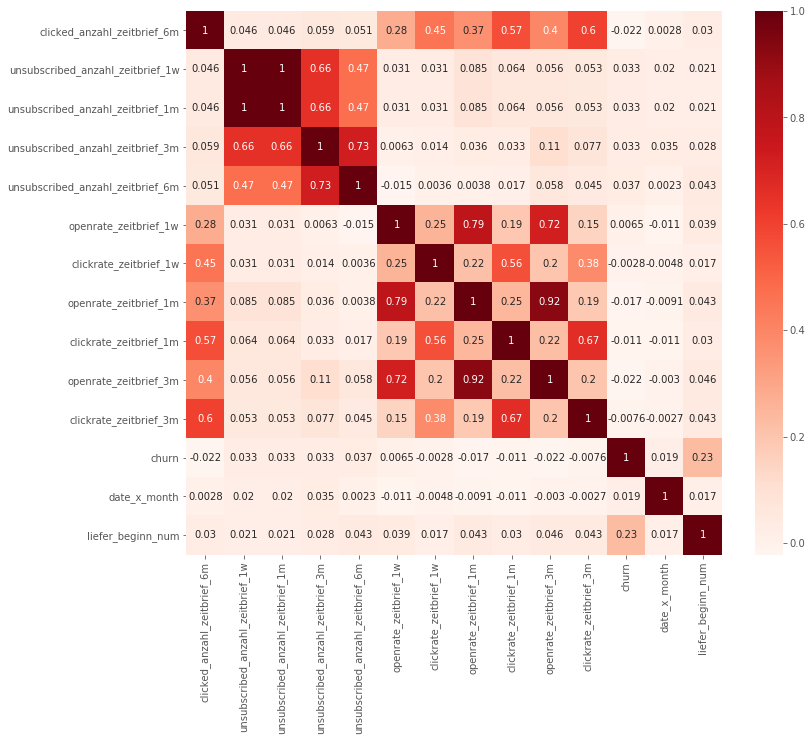

In [75]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = num_df15.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

As we can see no numerical feature is highly correlated with the output variable 'churn'. The highest correlation is between 'churn' and 'avg_churn', but we have to drop 'avg_churn because of data leakage.  Because the 'avg_churn' feature was created with information from the 'churn' variable. The highest correlations to the label 'churn' show the variables 'liefer_beginn_num', nl_aktivitaet ', nl_zeitshop', 'lesedauer', 'studentenabo' and 'cnt_umwandlungsstatus2_dkey'. What we can still see is that there are very high correlations between many other features.

## Feature Engineering

We take the year from 'abo_registrierung_min' and 'nl_registrierung_min' save them in two new variables, because the information is in the year.

In [76]:
df1['abo_registrierung_min_jahr'] = df1['abo_registrierung_min'].str[:4].astype('int')
df1['nl_registrierung_min_jahr'] = df1['nl_registrierung_min'].str[:4].astype('int')

In [77]:
df1.drop(['abo_registrierung_min', 'nl_registrierung_min'],axis=1,inplace=True)

In [78]:
df1.shape

(175045, 172)

### Dummie Variables

In [80]:
df1.select_dtypes(exclude=['int', 'float']).columns

Index(['auftrag_new_id', 'liefer_beginn_evt', 'kanal', 'objekt_name',
       'aboform_name', 'zahlung_rhythmus_name', 'zahlung_weg_name', 'plz_1',
       'plz_2', 'plz_3', 'ort', 'land_iso_code', 'anrede', 'titel', 'date_x'],
      dtype='object')

In [81]:
df1.drop(['date_x', 'ort', 'auftrag_new_id', 'liefer_beginn_evt'],axis=1,inplace=True)

In [82]:
df1 = pd.get_dummies(df1, columns = ['kanal', 'objekt_name',
       'aboform_name', 'zahlung_rhythmus_name', 'zahlung_weg_name', 'plz_1',
       'plz_2', 'plz_3', 'land_iso_code', 'anrede', 'titel'], drop_first = True)


In [83]:
df1.select_dtypes(exclude=['int', 'float']).columns

Index(['kanal_B2B', 'kanal_E-Mailing', 'kanal_Eigenwerbung',
       'kanal_Fremdwerbung', 'kanal_Mailings', 'kanal_SEA',
       'kanal_Standwerbung', 'kanal_Telefonmarketing', 'kanal_andere',
       'objekt_name_DIE ZEIT - CHRIST & WELT',
       ...
       'plz_3_999', 'plz_3_xx', 'land_iso_code_CH', 'land_iso_code_DE',
       'land_iso_code_andere', 'anrede_Frau', 'anrede_Herr',
       'anrede_unbekannt', 'titel_kein Titel', 'titel_sonstiger Titel'],
      dtype='object', length=833)

In [84]:
df1.shape

(175045, 990)

In [85]:
X, y = df1.drop('churn',axis=1), df1[['churn']]

### Feature Selection

/Users/sebastianfuhrer/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Text(0.5, 1.0, 'Top Features derived by Random Forest')

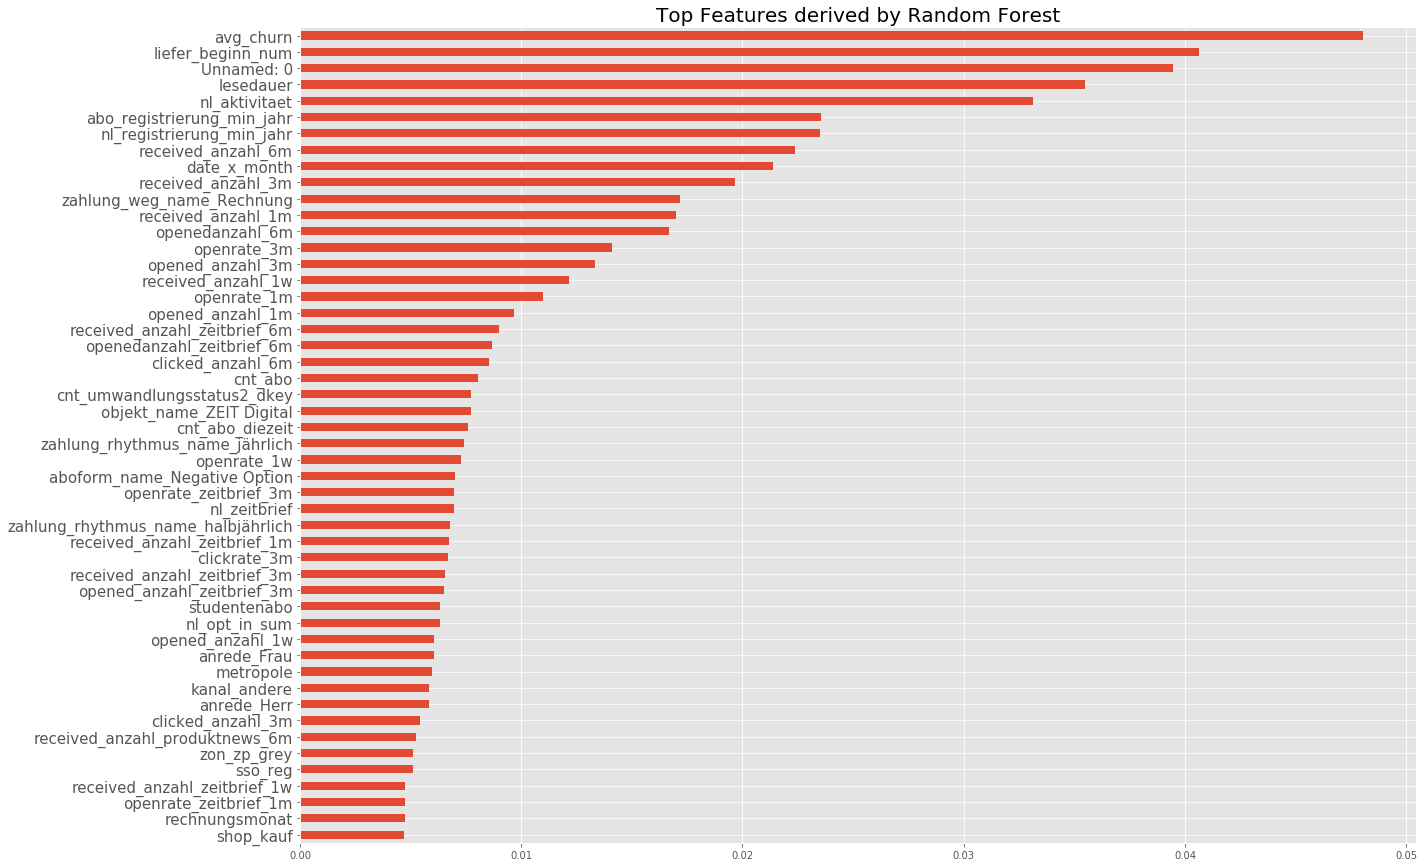

In [86]:
## To look for top features using Random Forest
# Create decision tree classifer object
rfc = RandomForestClassifier(random_state=0, n_estimators=100)

# Train model, note that NO scaling is required
model = rfc.fit(X, y)

# Plot the top features based on its importance
(pd.Series(model.feature_importances_, index=X.columns)
   .nlargest(50)   # can adjust based on how many top features you want
   .plot(kind='barh', figsize=[20,15])
    .invert_yaxis()) # Ensures that the feature with the most importance is on top, in descending order

plt.yticks(size=15)
plt.title('Top Features derived by Random Forest', size=20)

The highest correlation is between 'churn' and 'avg_churn', but we have to drop 'avg_churn because of data leakage. Because the 'avg_churn' feature was created with information from the 'churn' variable.

## Building a Preprocessing Pipeline

In [87]:
# Dropping the unnecessary columns 
df1.drop(['Unnamed: 0', 'training_set'],axis=1,inplace=True)

We drop 'Unnamed: 0' because its only an index column and we also drop the 'training_set' column because there are only ones in this column without explanatory content.

In [113]:
# Creating list for categorical predictors/features 
cat_features = list()
cat_features

[]

In [126]:
# Creating list for numerical predictors/features
num_features = list(['liefer_beginn_num', 'lesedauer', 'nl_aktivitaet', 'abo_registrierung_min_jahr',
                   'nl_registrierung_min_jahr', 'received_anzahl_6m', 'date_x_month', 'received_anzahl_3m',
                   'received_anzahl_1m', 'openedanzahl_6m', 'openrate_3m', 'opened_anzahl_3m', 'received_anzahl_1w',
                   'openrate_1m', 'opened_anzahl_1m', 'received_anzahl_zeitbrief_6m', 'openedanzahl_zeitbrief_6m',
                   'clicked_anzahl_6m', 'cnt_abo', 'zahlung_weg_name_Rechnung'])
num_features

['liefer_beginn_num',
 'lesedauer',
 'nl_aktivitaet',
 'abo_registrierung_min_jahr',
 'nl_registrierung_min_jahr',
 'received_anzahl_6m',
 'date_x_month',
 'received_anzahl_3m',
 'received_anzahl_1m',
 'openedanzahl_6m',
 'openrate_3m',
 'opened_anzahl_3m',
 'received_anzahl_1w',
 'openrate_1m',
 'opened_anzahl_1m',
 'received_anzahl_zeitbrief_6m',
 'openedanzahl_zeitbrief_6m',
 'clicked_anzahl_6m',
 'cnt_abo',
 'zahlung_weg_name_Rechnung']

In [125]:
# Define predictors and target variable
X = df1[['liefer_beginn_num', 'lesedauer', 'nl_aktivitaet', 'abo_registrierung_min_jahr',
                   'nl_registrierung_min_jahr', 'received_anzahl_6m', 'date_x_month', 'received_anzahl_3m',
                   'received_anzahl_1m', 'openedanzahl_6m', 'openrate_3m', 'opened_anzahl_3m', 'received_anzahl_1w',
                   'openrate_1m', 'opened_anzahl_1m', 'received_anzahl_zeitbrief_6m', 'openedanzahl_zeitbrief_6m',
                   'clicked_anzahl_6m', 'cnt_abo', 'zahlung_weg_name_Rechnung']].copy()
y = df1['churn']
print(X.shape)
print(y.shape)

(175045, 20)
(175045,)


## Model 

### Preprocessing

In [116]:
# Split into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)

In [117]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (140036, 47)
X_test shape: (35009, 47)
y_train shape: (140036,)
y_test shape: (35009,)


In [118]:
# Pipline for numerical features
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

In [119]:
# Complete pipeline
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

### Pipeline

In [120]:
models={'logreg': LogisticRegression(max_iter=1000, random_state=RSEED,n_jobs=-1),
        'tree': DecisionTreeClassifier(criterion = "gini", max_depth=3,random_state=RSEED),
        'forest': RandomForestClassifier(random_state=RSEED, max_features='sqrt', n_jobs=-1),
        'XGB' : XGBClassifier(random_state=RSEED,  n_jobs=-1),
        'AdaBoost' : AdaBoostClassifier(random_state=RSEED)}

### Predictive Modeling

In [121]:
results = pd.DataFrame(columns=['Model','Accuracy','Recall','Precision'])
i=0

for m in models.items():
    # Building a full pipeline with our preprocessor and a Classifier
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        (m[0], m[1])
    ])

    # Making predictions on the training set using cross validation as well as calculating the probabilities 
    y_train_predicted = cross_val_predict(pipe, X_train, y_train.values.ravel(), cv=5, verbose=5)

    # Calculating the accuracy for the LogisticRegression Classifier
    temp = pd.DataFrame({
        'Model': m[0],
        'Accuracy': accuracy_score(y_train, y_train_predicted),
        'Recall' : recall_score(y_train, y_train_predicted),
        'Precision': precision_score(y_train, y_train_predicted)
    }, index=[i])
    i+=1

    results = pd.concat([results, temp])
    print('Cross validation scores:')
    print('-------------------------')
    print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted)))
    print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted)))
    print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   28.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   39.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   51.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Cross validation scores:
-------------------------
Accuracy: 0.74
Recall: 0.31
Precision: 0.63


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Cross validation scores:
-------------------------
Accuracy: 0.73
Recall: 0.26
Precision: 0.62


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   44.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   55.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Cross validation scores:
-------------------------
Accuracy: 0.82
Recall: 0.54
Precision: 0.79


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   45.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   56.7s finished


Cross validation scores:
-------------------------
Accuracy: 0.75
Recall: 0.36
Precision: 0.67


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   26.7s remaining:    0.0s


Cross validation scores:
-------------------------
Accuracy: 0.74
Recall: 0.35
Precision: 0.64


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.7s finished


In [122]:
results.round(2)

,Model,Accuracy,Recall,Precision
0,logreg,0.74,0.31,0.63
1,tree,0.73,0.26,0.62
2,forest,0.82,0.54,0.79
3,XGB,0.75,0.36,0.67
4,AdaBoost,0.74,0.35,0.64


### Optimizing AdaBoost (Precision)

We optimize according to precision! Why?

We may be able to prevent any customer who really wants to cancel their subscription and whom we recognize as such from taking appropriate measures. That would be a source to generate additional money. Now comes the big but. Every customer we mistakenly identify as a migrating customer costs us money. Therefore, the model must be very precise in these cases.

In [109]:
ADA_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('AdaBoost', AdaBoostClassifier(random_state=RSEED))
    ])
ADA_param_grid = {
    'AdaBoost__n_estimators':[50, 100, 150, 200, 250, 300],                
    'AdaBoost__learning_rate':[0.1, 0.5, 1.]}  

In [110]:
ADA_grid = GridSearchCV(ADA_pipe, param_grid=ADA_param_grid, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1)
ADA_grid.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 10.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer_num',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                

In [111]:
# Show best parameters
print('Best score:\n{:.2f}'.format(ADA_grid.best_score_))
print("Best parameters:\n{}".format(ADA_grid.best_params_))

Best score:
0.65
Best parameters:
{'AdaBoost__learning_rate': 0.1, 'AdaBoost__n_estimators': 100}


In [112]:
# Save best model as best_model
ADA_best_model = ADA_grid.best_estimator_['AdaBoost']

In [113]:
preprocessor.fit(X_train)
X_train_preprocessed = preprocessor.transform(X_train)
y_train_predicted = ADA_best_model.predict(X_train_preprocessed)
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted)))

Accuracy: 0.73
Recall: 0.25
Precision: 0.65


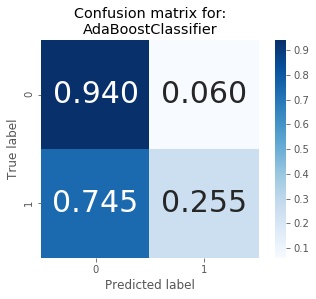

In [115]:
cm = confusion_matrix(y_train, ADA_best_model.predict(X_train_preprocessed))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
# normalize the data
# view with a heatmap
plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30},
            cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for:\n{}'.format(ADA_best_model.__class__.__name__));

### Optimizing Random Forest (Precision) via Grid Search

In [116]:
forest_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('forest', RandomForestClassifier(random_state=RSEED, n_jobs=-1))
    ])
forest_param_grid = {
    'forest__min_samples_split': [3, 5, 10],
    'forest__n_estimators' : [100, 300, 500],
    'forest__max_depth': [1, 3, 5, 10],
    'forest__max_features': [3, 5, 7, 10, 20, 30]}

In [117]:
forest_grid = GridSearchCV(forest_pipe, param_grid=forest_param_grid, cv=3, scoring='precision', 
                           verbose=10, n_jobs=-1)
forest_grid.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  9

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer_num',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                

In [118]:
# Show best parameters
print('Best score:\n{:.2f}'.format(forest_grid.best_score_))
print("Best parameters:\n{}".format(forest_grid.best_params_))

Best score:
0.70
Best parameters:
{'forest__max_depth': 3, 'forest__max_features': 3, 'forest__min_samples_split': 3, 'forest__n_estimators': 500}


In [119]:
# Save best model as best_model
forest_best_model = forest_grid.best_estimator_['forest']

preprocessor.fit(X_train)
X_train_preprocessed = preprocessor.transform(X_train)

y_train_predicted_forest = forest_best_model.predict(X_train_preprocessed)
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted_forest)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted_forest)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted_forest)))

Accuracy: 0.71
Recall: 0.08
Precision: 0.70


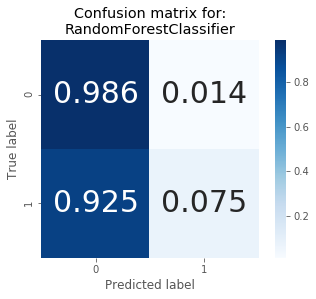

In [120]:
cm = confusion_matrix(y_train, forest_best_model.predict(X_train_preprocessed))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
# normalize the data
# view with a heatmap
plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30},
            cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for:\n{}'.format(forest_best_model.__class__.__name__));

### Final evaluation 

#### AdaBoost 

In [121]:
# Preparing the test set 
preprocessor.fit(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [122]:
# Calculating the accuracy, recall and precision for the test set with the optimized model
y_test_predicted = ADA_best_model.predict(X_test_preprocessed)

print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted)))

Accuracy: 0.73
Recall: 0.25
Precision: 0.64


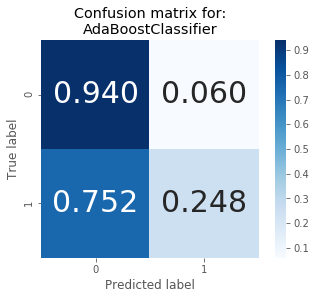

In [123]:
cm = confusion_matrix(y_test, ADA_best_model.predict(X_test_preprocessed))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
# normalize the data
# view with a heatmap
plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30},
            cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for:\n{}'.format(ADA_best_model.__class__.__name__));

The Ada Boost Model already fulfills the demands we have of our model relatively well. Our goal is to keep the second type of error as small as possible. Our model should predict as little as possible true loyal customers as unfaithful customers and at the same time our model should predict customers churn as much as possible. The Ada Boost model keeps the second type of error small with 6% and still catches almost 25% of customers who want to cancel their subscription.

#### Random Forest 

In [124]:
# Calculating the accuracy, recall and precision for the test set with the optimized model
forest_y_test_predicted = forest_best_model.predict(X_test_preprocessed)

print("Accuracy: {:.2f}".format(accuracy_score(y_test, forest_y_test_predicted)))
print("Recall: {:.2f}".format(recall_score(y_test, forest_y_test_predicted)))
print("Precision: {:.2f}".format(precision_score(y_test, forest_y_test_predicted)))

Accuracy: 0.71
Recall: 0.07
Precision: 0.68


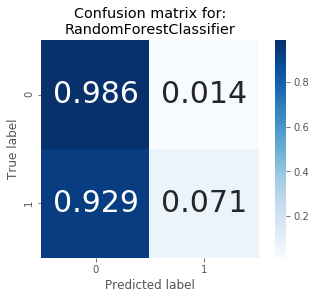

In [125]:
cm = confusion_matrix(y_test, forest_best_model.predict(X_test_preprocessed))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
# normalize the data
# view with a heatmap
plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30},
            cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for:\n{}'.format(forest_best_model.__class__.__name__));

The Random Forest Model is not really suitable. At 1.4%, the second type of error is even smaller than with the Ada Boost model, but the model hardly predicts customers who want to cancel their subscription with 7.1%.

## Future Work

We want to create a model that keeps the second type of error small and predicts even more customers who want to churn.